# Concept Relevance Propagation - Tutorial on Attributions

This tutorial is the first of two tutorials where the core of the toolbox is introduced: *Conditional Attributions*.

After the basics are mastered, you can move on to the second tutorial: *Feature Visualization*.

### Table of Contents

* [Introduction: Behind The Scenes](#introduction-behind-the-scenes). How does zennit-crp work?
* [Computing Conditional Heatmaps](#computing-conditional-attributions). How are conditional heatmaps computed using the _CondAttribution_ class?
    * [Broadcasting](#21-broadcasting)
    * [Relevance Initialization](#22-initializing-relevance)
    * [Recording and Attributing Latent Concept Relevances](#23-recording-and-attributing-latent-concept-relevances)
    * [Conditions with Several Layers](#24-conditions-with-several-layers)
* [Generator Expression for Maximal Performance](#3-generator-expression-for-maximal-performance). Squeeze out maximal performance utilizing the generator expression of the _CondAttribution_ class.
    * [Local Analysis](#31-local-analysis). Find concepts concentrated in a specific part of the input image.
* [Decomposition of Higher-Level Concepts](#4-decomposition-of-higher-level-concepts). Decompose higher-level concepts into lower-level concepts.
    * [Attribution Graph](#5-attribution-graph). A convenient wrapper.


In a future release of this tutorial, we will
- apply our insights to extend CRP to _Integrated Gradient_ or to write your own CRP implementation in the future!
- define new notions of concepts by modifiyng the _Concept_ class



### 1. Introduction: Behind The Scenes

The CRP toolbox builds on [zennit](https://github.com/chr5tphr/zennit). It takes advantage of PyTorch’s autograd module to compute gradients in computational graphs.
zennit modifies the backpropagated gradient in such a way that they are replaced by attributions. The library is highly customizable with a focus on [LRP](http://www.heatmapping.org/) (Layer-wise Relevance Propagation), while other popular techniques like [Integrated Gradient](https://arxiv.org/abs/1703.01365) are also available. Please refer to the well written [zennit documentation](https://zennit.readthedocs.io/en/latest/) before you continue.

**Don't worry**, to use CRP you don't need to understand how this toolbox works exactly. However, for the interested reader, we'll briefly elaborate on it:

<img src="images/exclude_parallel.svg"  width="1000" style="background-color:white;">

In a backward pass, PyTorch would usually pass the gradients from all neurons of a higher layer to the lower layers and mix them up, however CRP works by passing only specific parts of the gradients and zeroing out the others. Zennit replaces these gradients with actual attribution scores that flow from the last layer to the first one.

In the Image **a)** you see, that we only pass the attributions of the neuron '0' in layer 'layer3' to the next layers. And then again pass only the attributions of neuron '0' and '2' in layer 'layer1' to the input.
If we were to implement this with a normal PyTorch [backward hook](https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_full_backward_hook.html) in layer 'layer1', we would write the following code that sets the input gradient to zero everywhere except for the neurons '0' and '2':

In [1]:
import torch

def mask_hook(module, grad_input, grad_output):
    mask = torch.zeros_like(grad_input)
    # first dimension is the batch, second dimension the neuron indices for a MLP layer
    mask[0, [0, 2]] = 1
    return grad_input * mask

### please don't run
# h = layer1.register_module_full_backward_hook(mask_hook)
# output.backward()

In the Image **b)** you see another important method how masking could be performed:
Imagine, that we want to compute the *sole* contribution of 'layer1' to the input image, in this case we must zeroing out all parallel layers _i.e._ 'layer2', so that we get a heatmap illustrating where only 'layer1' is looking at. As a result, the attribution in **a)** looks completely different vs. in **b)**.

To do this, we could manually search for all parallel layers and set their gradients to zero. Alternatively, we could just use the PyTorch [autograd engine](https://pytorch.org/docs/stable/generated/torch.autograd.grad.html) to calculate the gradient between 'layer1' and 'layer3' and ignore 'layer2' using the following code:

In [2]:
### please don't run
# grad, = torch.autograd.grad(output, layer3_output)
# torch.autograd.grad(layer3_output, layer1_output, grad)

This toolbox allows for both modes and will by default differentiate as in **b)**, since in practice, we want to compute the heatmaps for isolated CNN channels or neurons without interference from other parallel layers.


How our concepts are defined in latent space has an effect on how masking must be applied in a layer. By default, we define each channel in a CNN layer or each neuron in a MLP layer as an independent concept. That is, complete channels are masked. 
This is represented by the `ChannelConcept` class, which implements all necessary transformations for us. Alternatively, own concepts can be defined.

In [3]:
from crp.concepts import ChannelConcept

cc = ChannelConcept()

The `mask` method of the `ChannelConcept` class returns a function similar to the previous mask_hook function.
`ChannelConcept.mask` allows to mask individual channels as well as MLP neurons per batch.

In [5]:
# mask channel 0 and 2 in batch 0
mask_fn = cc.mask(0, [0, 2])

mask_fn(torch.ones((2, 4, 2, 2)))

tensor([[[[1., 1.],
          [1., 1.]],

         [[0., 0.],
          [0., 0.]],

         [[1., 1.],
          [1., 1.]],

         [[0., 0.],
          [0., 0.]]],


        [[[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]]]])

### 2. Computing Conditional Heatmaps

Let's start by importing a pretrained model from the PyTorch library: The VGG16 with BatchNorm layers. In addition, we load in an example image of a lizard.

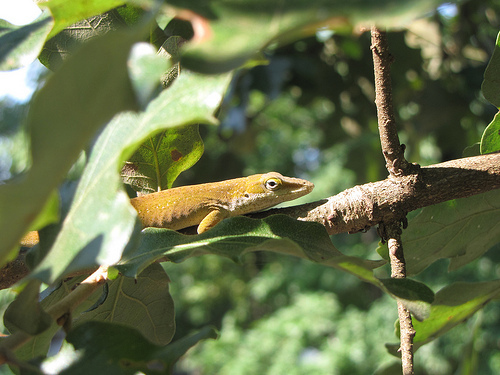

In [6]:
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = vgg16_bn(True).to(device)
model.eval()

transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
image = Image.open("images/lizard.jpg")
sample = transform(image).unsqueeze(0).to(device)

image

Now, we first define a zennit composite and a suitable canonization. Then, we use the `CondAttribution` class that contains the functionality to compute conditional heatmaps and intermediate activations as well as relevances. By default, the `no_param_grad` flag sets the requires_grad attributes of the model parameters to False, to save GPU memory since we don't need them.

In [7]:
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution

composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(model, no_param_grad=True)

To compute attributions, we first define a condition set that indicates wrt. which class the attribution should be initialized. The keyword "y" is used for this purpose. 

Secondly, we define how concepts are masked by setting the mask_map parameter to `cc.mask`.
If you have different concepts in different layers, you can define alternatively a dictionary where the keys are the layer names and the values different mask functions. For convenience, we use the `get_layer_names` function that returns the name of all layers of a specific type.

In [12]:
from crp.helper import get_layer_names

# compute heatmap wrt. output 46 (green lizard class)
conditions = [{"y": 46}]

# zennit requires gradients
sample.requires_grad = True
attr = attribution(sample, conditions, composite, mask_map=cc.mask)

# or use a dictionary for mask_map
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
mask_map = {name: cc.mask for name in layer_names}

attr = attribution(sample, conditions, composite, mask_map=mask_map)

Per default, `mask_map` is set to `ChannelConcept.mask`. That's why, we will omit the parameter from now on.

`attr` is from Python type [namedtuple](https://docs.python.org/3/library/collections.html#collections.namedtuple). Its elements can be accessed by indexing or by name. 

Let's plot the heatmap using the inbuilt function `imgify`.

True


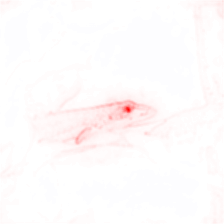

In [13]:
from crp.image import imgify

print(torch.equal(attr[0], attr.heatmap))

imgify(attr.heatmap, symmetric=True)


More general, the condition set is a list of dictionaries that have the layer name as key and a list of integer concept identifiers as value. Computing the heatmap for channel 35 in layer features.40 conditioned on output 46 (lizard), we write:

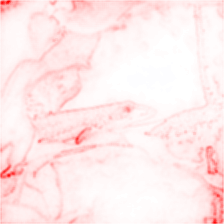

In [14]:
# compute heatmap of channel 35 in layer features.40 conditioned on output 46 (green lizard class) 
conditions = [{"y": [46], "features.40": [35]}]
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True)

That's looking completely different! The reason is, that the heatmap now illustrates on what parts of the input image the channel activates. In this case, the channel activates on the vegetation. In the tutorial on feature visualization we will have a deeper look! Note, the standard heatmap (first one) displays minimal relevance on the environment, although the vegetation is very important for classification, as we will show later. This is due to the fact that the intensity of the red color is propotional to the relevance density at a pixel. While relevance is concentrated on the lizard's eye (high density), relevance on the vegetation is widely dispersed (low density).

It is **important** to note that the keyword "y" is reserved and describes how the backward pass should be initialized. No layer in the model may have the name "y". If it has, simply set the parameter `attribution.MODEL_OUTPUT_NAME` to another keyword.

### 2.1 Broadcasting

We can also pass several conditions in one list. If we analyze a sample with batch size 1, the sample is automatically expanded in its batch size to the length of the conditions.

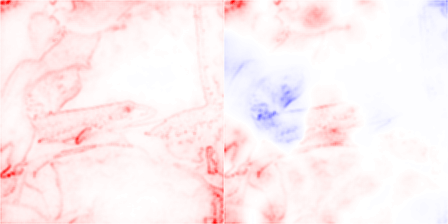

In [15]:

conditions = [{"features.40": [35], "y": [46]}, {"features.20": [10], "y": [2]}]
heatmaps, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmaps, symmetric=True, grid=(1, len(heatmaps)))

### 2.2 Initializing Relevance

Per default, relevance is initialized with the model output value. But you can also change the way, how relevance is initialized by setting the `init_rel` parameter to a callable function or an integer value. Refer to the `relevance_init` method of the `CondAttribution` class.

However, we recommend to initialize relevance with the prediction value i.e. the default setting.

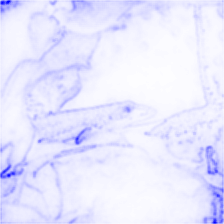

In [16]:
conditions = [{"y": [46], "features.40": [35]}]
heatmap, _, _, _ = attribution(sample, conditions, composite, init_rel=-1)

imgify(heatmap, symmetric=True)

Let's say, we want to initialize the relevance at the logit position of the highest confidence, then we could define the following function and omit the "y" parameter:

wrt. class 40


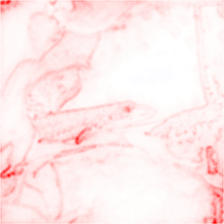

In [17]:
softmax = torch.nn.Softmax(dim=-1)
def select_max(pred):
    id = softmax(pred).argmax(-1).item()
    print(f"wrt. class {id}")
    mask = torch.zeros_like(pred)
    mask[0, id] = pred[0, id]
    return mask

conditions = [{"features.40": [35]}]
heatmap, _, _, _ = attribution(sample, conditions, composite, init_rel=select_max)
imgify(heatmap, symmetric=True)

You can also start the backward pass at an intermediate layer by firstly ommiting the "y" keyword and secondly by setting the `start_layer` parameter to the desired layer name. The `backward_initialization` method of the `CondAttribution` class is then called at the output of the selected layer. In other words: relevance is initialized with the activation of this layer.

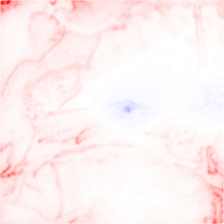

In [18]:
conditions = [{"features.40": [35]}]

heatmap, _, _, _ = attribution(sample, conditions, composite, start_layer="features.40")

imgify(heatmap, symmetric=True)

As you can see, this time the eye of the lizard appears to have negative 'relevance', although we try to explain the same channel. This is due to the fact, that neurons, that perceive the eye, have a negative activation output. Initializing with negative activation inverts the heatmap.
Thus, this image illustrates which regions in the input image activate the channel positively or negatively.
But if we condition the heatmap also on a class, as in our first run in this notebook, the heatmap depicts which part of the input features, that activate the filter, are relevant for the prediction of the class 'lizard'. 

### 2.3 Recording and Attributing Latent Concept Relevances

In order for us to know which concepts are most decisive for a prediction, we need to record the relevances of the intermediate layers. For this, we can pass a list of layer names to the `record_layer` parameter. For convenience, we use the `get_layer_names` function that returns the name of all layers of a specific type.

In [19]:
from crp.helper import get_layer_names

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

conditions = [{'y': [46]}]
attr = attribution(sample, conditions, composite, record_layer=layer_names)

attr.activations['features.40'].shape, attr.relevances['features.40'].shape
# attr[1]["features.40"].shape, attr[2]["features.40"].shape # is equivalent

(torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 14, 14]))

The `attribute` method of the `ChannelConcept` class assigns relevance to each concept. The first element corresponds to the first channel and so on. The `abs_norm` flag normalizes relevance by dividing by the sum of absolute value.

In [20]:
# layer features.40 has 512 channel concepts
rel_c = cc.attribute(attr.relevances['features.40'], abs_norm=True)
rel_c.shape

torch.Size([1, 512])

In [21]:
# the six most relevant concepts and their contribution to final classification in percent
rel_values, concept_ids = torch.topk(rel_c[0], 6)
concept_ids, rel_values*100

(tensor([469,  35,  71,  89, 161, 316], device='cuda:0'),
 tensor([8.9678, 5.0505, 4.5648, 1.9458, 1.9447, 1.6571], device='cuda:0'))

Let's look at their conditional heatmaps!

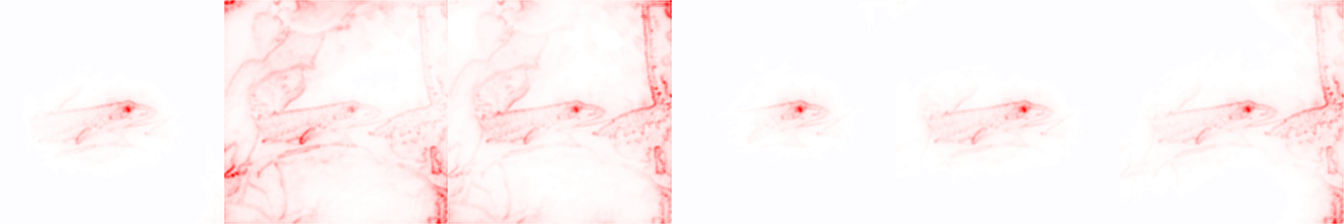

In [22]:
conditions = [{'features.40': [id], 'y': [46]} for id in concept_ids]

heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(concept_ids)))

Some concepts focus on the body of the lizard, but some on the surroundings. The second, third and last channel seem to be Clever Hans artifacts, since the lizard should be detected by itself and not by the environment. We will explore the concepts in more depth in the next notebook on Feature Visualization.

### 2.4 Conditions with Several Layers

If you have a conditions set with several layers i.e.

In [23]:
conditions = [{"features.40": [35], "features.36": [24], "y": [46]}]

Then, the posterior layers must be named first i.e features.40 > features.36 ("y" doesn't matter).

For those who have read the Section [Behind The Scenes](#1-introduction-behind-the-scenes), mode **b)** is implemented by default. This is recognizable by the `exclude_parallel=True` flag. Try out changing the order, and you will see an error message (-:
Mode **a)** is executed with `exclude_parallel=False` and then the order of the layer names does not matter anymore.

In [24]:
attr = attribution(sample, conditions, composite, exclude_parallel=True)

### 3. Generator Expression for Maximal Performance

In practical applications, it is important to compute the conditional heatmap for all concepts in a layer for the same sample. The generator expression automatically expands the input sample in its batch size and iterates through a list of concept ids. The beauty here is that the forward pass is executed only once and the computational graph is kept in memory. Thus, each attribution iterates through the same backward graph, roughly doubling the performance. 

Note, if you overwrite the method `backward_initialization` of the `CondAttribution` class, the `retain_graph` parameter must be set for this.

In [25]:
conditions = [{'features.40': [id], 'y': [46]} for id in torch.arange(0, 512)]

for attr in attribution.generate(sample, conditions, composite, record_layer=layer_names, batch_size=10):
    pass

100%|██████████| 52/52 [00:08<00:00,  6.20it/s]


If `exclude_parallel=True`, all layer names must be identical in each `dict` of the condition `list`.

### 3.1 Local Analysis

Using the generator expression, we compute which concepts are relevant for the branch on which the lizard is sitting. The idea is to locate the concepts with the conditonal heatmap in the input space and then sum up the relevance that falls on the branch. The concepts with the highest values are used by the model to detect branch-like patterns. 

For this, we define a binary mask on the branch and supply it to the `cc.attribute` method.

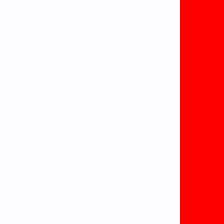

In [26]:
mask = torch.zeros(224, 224).to(attribution.device)
mask[:, 180:] = 1

imgify(mask, symmetric=True)

In [27]:
from crp.helper import abs_norm

rel_c = []
for attr in attribution.generate(sample, conditions, composite, record_layer=layer_names, batch_size=10):
    
    masked = attr.heatmap * mask[None, :, :]
    rel_c.append(torch.sum(masked, dim=(1, 2)))

rel_c = torch.cat(rel_c)

indices = torch.topk(rel_c, 5).indices
# we norm here, so that we clearly see the contribution inside the masked region as percentage
indices, abs_norm(rel_c)[indices]*100

100%|██████████| 52/52 [00:08<00:00,  6.17it/s]


(tensor([ 71, 316,  35, 413, 469], device='cuda:0'),
 tensor([8.8463, 7.4042, 6.6325, 2.9865, 2.8506], device='cuda:0'))

### 4. Decomposition of Higher-Level Concepts

With the help of the toolbox we can also find out which lower-level concepts activate a high-level concept.
In this way, we can observe how, piece by piece, hierarchically higher semantics emerge from lower-level concepts.

For this we only need to add the desired concept and layer in the condition set and record the relevances in the following layer.

In [28]:
conditions = [{"y": [46], "features.40": [469]}]

attr = attribution(sample, conditions, composite, record_layer=["features.37"])

rel_c = cc.attribute(attr.relevances["features.37"], abs_norm=True)

# five concepts in features.37 that contributed the most to the activation of channel 469 in features.40
# while being relevant for the classification of the lizard class
torch.argsort(rel_c, descending=True)[0, :5]

tensor([ 28, 269, 311, 233, 246], device='cuda:0')

### 4.1 Attribution Graph

Because we often don't know which layers follow which layers in large, complex models and the set of conditions may grow rapidly, we provided an `AttributionGraph` class that decomposes concepts for us.

Since Python currently does not allow to return a summary about the connection between layers like tensorflow does, there is no easy way to find out which layers are connected to which ones.
For the Attribution Graph, we have programmed our own module that does this work for us. 
It works by tracing a graph via `torch.jit` and parsing its output. The result of this procedure is stored in a `ModelGraph` object. You can generate the graph using the `trace_model_graph` function.
_Note, however, that this module might be unstable since we are using unofficial, undocumented PyTorch library interfaces._

In [29]:
from crp.graph import trace_model_graph

graph = trace_model_graph(model, sample, layer_names)
print(graph)

__module.features/__module.features.0 -> __module.features/__module.features.1, 
__module.features/__module.features.1 -> __module.features/__module.features.2, 
__module.features/__module.features.2 -> __module.features/__module.features.3, 
__module.features/__module.features.3 -> __module.features/__module.features.4, 
__module.features/__module.features.4 -> __module.features/__module.features.5, 
__module.features/__module.features.5 -> __module.features/__module.features.6, 
__module.features/__module.features.6 -> __module.features/__module.features.7, 
__module.features/__module.features.7 -> __module.features/__module.features.8, 
__module.features/__module.features.8 -> __module.features/__module.features.9, 
__module.features/__module.features.9 -> __module.features/__module.features.10, 
__module.features/__module.features.10 -> __module.features/__module.features.11, 
__module.features/__module.features.11 -> __module.features/__module.features.12, 
__module.features/__mod

You can return the input layers of a layer through the `find_input_layers` method.

In [30]:
graph.find_input_layers("features.40")

['features.37']

For the `AttributionGraph` class, we supply a `CondAttribution` object, a `ModelGraph` object and a layer_map dictionary. The layer_map contains as keys the layer names and as values concepts used in a layer.

In [31]:
from crp.attribution import AttributionGraph

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

layer_map = {name: cc for name in layer_names}
attgraph = AttributionGraph(attribution, graph, layer_map)

# decompose concept 71 in features.40 w.r.t. target 46 (lizard class)
# width=[5, 2] returns first the 5 most relevant concepts in the previous lower-level layer
# and in the second iteration returns for each of the 5 most relevant concepts again the two
# most relevant concepts in the previous lower-level layer
nodes, connections = attgraph(sample, composite, 71, "features.40", 46, width=[5, 2], abs_norm=True)
print("Nodes:\n", nodes, "\nConnections:\n", connections)

100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

Nodes:
 [('features.40', 71), ('features.37', 168), ('features.37', 349), ('features.37', 155), ('features.37', 246), ('features.37', 387), ('features.34', 7), ('features.34', 276), ('features.34', 423), ('features.34', 479), ('features.34', 493), ('features.34', 475), ('features.34', 310), ('features.34', 61), ('features.34', 381), ('features.34', 489)] 
Connections:
 {('features.40', 71): [('features.37', 168, 0.06278380006551743), ('features.37', 349, 0.05868234857916832), ('features.37', 155, 0.037121087312698364), ('features.37', 246, 0.02934243716299534), ('features.37', 387, 0.021685730665922165)], ('features.37', 168): [('features.34', 7, 0.057873766869306564), ('features.34', 276, 0.04606578126549721)], ('features.37', 349): [('features.34', 423, 0.06718029826879501), ('features.34', 479, 0.03555810824036598)], ('features.37', 155): [('features.34', 493, 0.043070659041404724), ('features.34', 475, 0.030511921271681786)], ('features.37', 246): [('features.34', 310, 0.0399979501

`nodes` is a list of tuples that contains all concepts inside the graph, where the first element is the layer name and the second element the concept index. 

`connections`, on the other hand, describes the connections between them. It is a dictionary with keys corresponding to the root node and the dictionary values are the child nodes. Each child node is a tuple of three elements, where the first is the layer name, the second is the concept index and the third is the relative relevance contribution.

In [32]:
connections[("features.40", 71)]

[('features.37', 168, 0.06278380006551743),
 ('features.37', 349, 0.05868234857916832),
 ('features.37', 155, 0.037121087312698364),
 ('features.37', 246, 0.02934243716299534),
 ('features.37', 387, 0.021685730665922165)]

As we can see, 6.2 % of relevance flows from channel 71 in layer features.40 to channel 168 in layer features.37.